# Bay Area Bike Share Data: August 2013 to August 2015

## Table of Contents

1. Read in All Data
2. TRIP DATA --> Filter to San Francisco data only & clean the data
3. TRIP DATA --> Descriptive Statistics & Data Visualization
4. Does the weather impact trips & duration?

## 1. Read in the data files

In [91]:
import os
os.chdir('/Users/matthewfederighi/Desktop/SMC/809-MarketingAnalytics/Project/')

In [92]:
import csv
import pandas as pd 
import datetime as datetime
from functools import reduce
import sqlite3
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from collections import Counter
import statsmodels.api as sm
from matplotlib import cm
import numpy as np

In [93]:
# Read in SQL lite file & take quick look at the data
# Subfile Names = station, status, trip, weather

conn = sqlite3.connect('BABS.sqlite')
db = conn.cursor()
station = pd.read_sql_query('SELECT * FROM station;',conn)
#status = pd.read_sql_query('SELECT * FROM status;',conn)
trip = pd.read_sql_query('SELECT * FROM trip;',conn)
weather = pd.read_sql_query('SELECT * FROM weather;',conn)
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4069,174,8/29/2013 9:08,2nd at South Park,64,8/29/2013 9:11,2nd at South Park,64,288,Subscriber,94114
1,4073,1067,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:42,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703
2,4074,1131,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115
3,4075,1117,8/29/2013 9:24,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122
4,4076,1118,8/29/2013 9:25,South Van Ness at Market,66,8/29/2013 9:43,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597


## 2. Filter Trips Data to SF & Clean

In [94]:
sfstations = pd.read_sql_query('SELECT * FROM station WHERE city = "San Francisco";',conn)
sfstationids = sfstations['id']
sftrips = trip[trip['start_station_id'].isin(sfstationids)].copy()

#### Check variable types to ensure proper formatting

In [95]:
sftrips.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

#### Convert to Datetime, Create new Date Column

In [96]:
sftrips.start_date = pd.DatetimeIndex(sftrips.start_date, format='%m/%d/%Y %H:%M')
sftrips.end_date = pd.DatetimeIndex(sftrips.end_date, format='%m/%d/%Y %H:%M')
sftrips['year'] = sftrips.start_date.dt.year
sftrips['month'] = sftrips.start_date.dt.month
sftrips['hour'] = sftrips.start_date.dt.hour
sftrips['day_of_week'] = sftrips.start_date.dt.weekday_name

In [97]:
sftrips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,year,month,hour,day_of_week
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2013,8,9,Thursday
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,2013,8,9,Thursday
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,2013,8,9,Thursday
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,2013,8,9,Thursday
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,2013,8,9,Thursday


#### Remove Outliers

Remove trips greater than 8 hours and less than 5 minutes. We are filtering because there are a few trips that lasted longer than 8 hours. This could be a technology error or someone may not have returned the bike. We've also filtered our trips less than 5 minutes because these could have been accidental rentals. 

In [98]:
sftrips_clean = sftrips[sftrips.duration <= 28800] # greater than 8 hours in seconds
sftrips_clean = sftrips[sftrips.duration >= 300]   # less than 5 minutes in seconds

#### Check for null values

In [99]:
sftrips_clean.isnull().sum() #no blanks in dataset

id                    0
duration              0
start_date            0
start_station_name    0
start_station_id      0
end_date              0
end_station_name      0
end_station_id        0
bike_id               0
subscription_type     0
zip_code              0
year                  0
month                 0
hour                  0
day_of_week           0
dtype: int64

We've filtered the data to San Francisco trips only, removed any outliers, & checked the data to ensure no missing values & proper formatting. The SF TRIP data looks clean and ready to go. Now, we will move onto visualizations.

## 3. Descriptive Statistics & Data Visualization

In [100]:
# Descriptive Stats in Minutes
(sftrips_clean['duration']/60 ).describe()

count    500743.000000
mean         19.870983
std         417.802719
min           5.000000
25%           7.333333
50%           9.833333
75%          13.650000
max      287840.000000
Name: duration, dtype: float64

#### Subscriber Type

In [101]:
# Define Colors
clr = ['#5F156A', '#E14F40']
color = cm.inferno_r(np.linspace(.4,.8, 30))

Text(0.5,0.98,'Subscription Type')

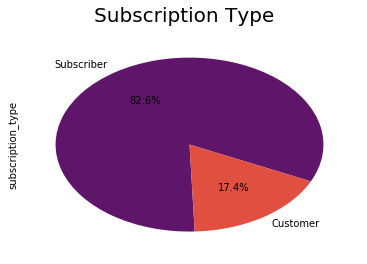

In [102]:
# Without Outliers removed
pd.value_counts(sftrips_clean['subscription_type']).plot.pie(autopct='%1.1f%%', startangle=-25, colors=clr)
plt.suptitle('Subscription Type', fontsize=20)

Interesting.. 82.6% of the trips are subscribers. <br>
As a refresher, subscribers are those who pay a flat, monthly fee for unlimited rides. Customers pay for single rides or pay for the day. 

#### Looking at the stations by frequency

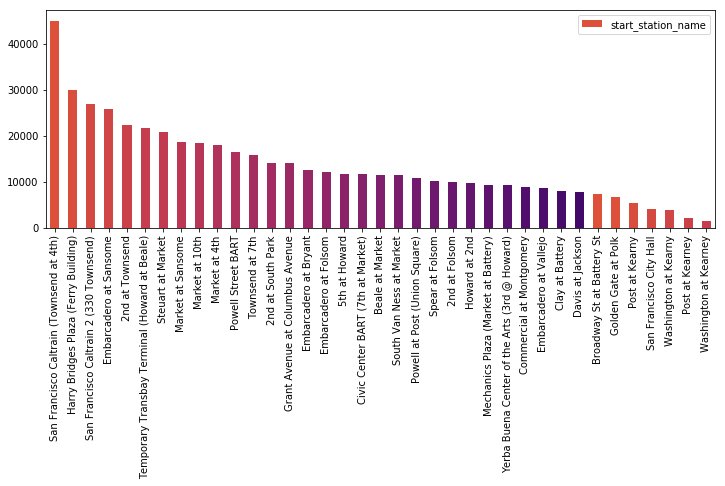

In [103]:
pd.value_counts(sftrips_clean['start_station_name']).plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))

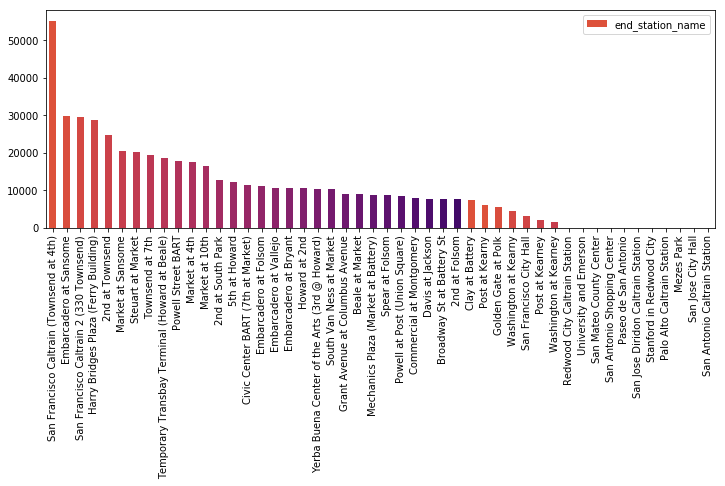

In [104]:
pd.value_counts(sftrips_clean['end_station_name']).plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))

Caltrain, Embarcadero, & Ferry Building stations seem to have the most bicycle traffic. With 82% of the data subscribers, this makes intuituve sense. Subscribers are using the bike service to commute to work. <br><br>
To solidify that assumption, let's take a look at the number of trips by day of the week and then by hour to see if we find a similar story. 

#### By Month
First, we need to get the counts for each month & duration for each month. 

In [105]:
monthdf = pd.read_sql_query('SELECT start_date, duration, subscription_type FROM trip;',conn)
monthdf.dtypes

start_date           object
duration              int64
subscription_type    object
dtype: object

In [106]:
monthdf.start_date = pd.DatetimeIndex(monthdf.start_date) # Convert to DatetimeIndex
monthdf['date'] = monthdf.start_date.dt.date   # Create a new date column
monthdf.date = pd.to_datetime(monthdf.date)    # Convert column to datetime
monthdf.head()

,start_date,duration,subscription_type,date
0,2013-08-29 09:08:00,174,Subscriber,2013-08-29
1,2013-08-29 09:24:00,1067,Subscriber,2013-08-29
2,2013-08-29 09:24:00,1131,Subscriber,2013-08-29
3,2013-08-29 09:24:00,1117,Subscriber,2013-08-29
4,2013-08-29 09:25:00,1118,Subscriber,2013-08-29


In [108]:
# Aggregate the data into a new dataframe for all trips
month_agg = monthdf.groupby('date').agg({'subscription_type':'count', 'duration': 'sum'})
month_agg.columns = ['counts', 'duration'] 

# Break down the data into 3 dfs by year
t13 = month_agg[month_agg.index.year.isin([2013])]
t14 = month_agg[month_agg.index.year.isin([2014])]
t15 = month_agg[month_agg.index.year.isin([2015])]

# Group Dataframes
a = t13.groupby(by=[t13.index.month, t13.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
b = t14.groupby(by=[t14.index.month, t14.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
c = t15.groupby(by=[t15.index.month, t15.index.year]).agg({'duration': 'sum', 'counts': 'sum'})

# Concat the Dataframes
bikeshare_all = pd.concat([a,b,c], axis=0)

# Reset the index
bikeshare_all_clean = bikeshare_all.reset_index(drop=True)

Phew. Pretty tedious, but now we can see if there are some upward trends for duration and total number of trips over the entire dataset. 

Text(0.5,0,'Month & Year')

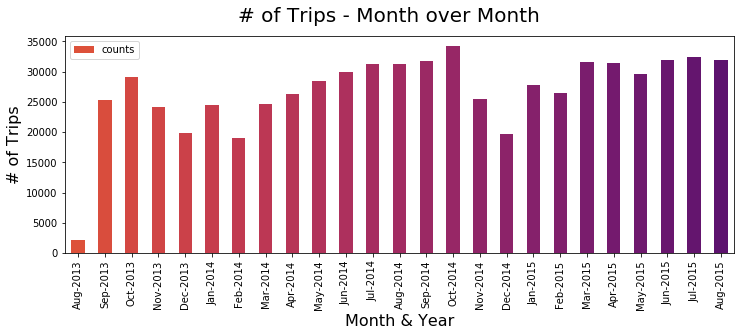

In [109]:
bikeshare_all_clean['counts'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('# of Trips - Month over Month', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

Hmm, that's pretty interesting. There does not appear to be significant upward trends in the dataset. Also, there doesn't appear to be much sign of seasonality. Trips and duration are relatively flat. We should segment the data into Customers and Subscribers to see if we can find anything interesting in the 2 segments. 

In [111]:
# Aggregate the data into a new dataframe for Subscribers
month_subscriber = monthdf.loc[monthdf['subscription_type'] == 'Subscriber']
month_agg_sub = month_subscriber.groupby('date').agg({'subscription_type':'count', 'duration': 'sum'})
month_agg_sub.columns = ['counts', 'duration'] 

# Break down the data into 3 dfs by year
t13_sub = month_agg_sub[month_agg_sub.index.year.isin([2013])]
t14_sub = month_agg_sub[month_agg_sub.index.year.isin([2014])]
t15_sub = month_agg_sub[month_agg_sub.index.year.isin([2015])]

# Group Dataframes
a_sub = t13_sub.groupby(by=[t13_sub.index.month, t13_sub.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
b_sub = t14_sub.groupby(by=[t14_sub.index.month, t14_sub.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
c_sub = t15_sub.groupby(by=[t15_sub.index.month, t15_sub.index.year]).agg({'duration': 'sum', 'counts': 'sum'})

# Concat the Dataframes
bikeshare_sub = pd.concat([a_sub,b_sub,c_sub], axis=0)

# Reset the index
bikeshare_sub_clean = bikeshare_sub.reset_index(drop=True)

In [112]:
# Aggregate the data into a new dataframe for Customers
month_customer = monthdf.loc[monthdf['subscription_type'] == 'Customer']
month_agg_cus = month_customer.groupby('date').agg({'subscription_type':'count', 'duration': 'sum'})
month_agg_cus.columns = ['counts', 'duration'] 

# Break down the data into 3 dfs by year
t13_cus = month_agg_cus[month_agg_cus.index.year.isin([2013])]
t14_cus = month_agg_cus[month_agg_cus.index.year.isin([2014])]
t15_cus = month_agg_cus[month_agg_cus.index.year.isin([2015])]

# Group Dataframes
a_cus = t13_cus.groupby(by=[t13_cus.index.month, t13_cus.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
b_cus = t14_cus.groupby(by=[t14_cus.index.month, t14_cus.index.year]).agg({'duration': 'sum', 'counts': 'sum'})
c_cus = t15_cus.groupby(by=[t15_cus.index.month, t15_cus.index.year]).agg({'duration': 'sum', 'counts': 'sum'})

# Concat the Dataframes
bikeshare_cus = pd.concat([a_cus,b_cus,c_cus], axis=0)

# Reset the index
bikeshare_cus_clean = bikeshare_cus.reset_index(drop=True)

Text(0.5,0,'Month & Year')

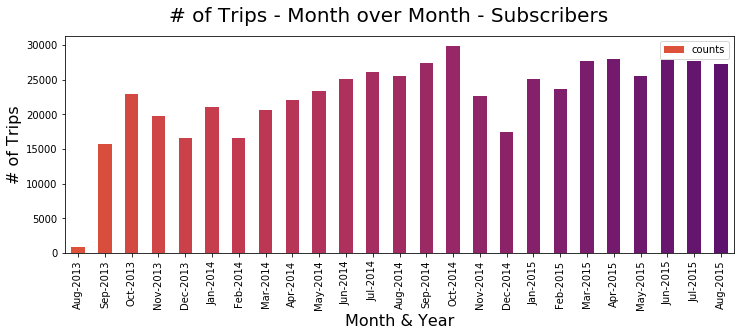

In [113]:
bikeshare_sub_clean['counts'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('# of Trips - Month over Month - Subscribers', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

Text(0.5,0,'Month & Year')

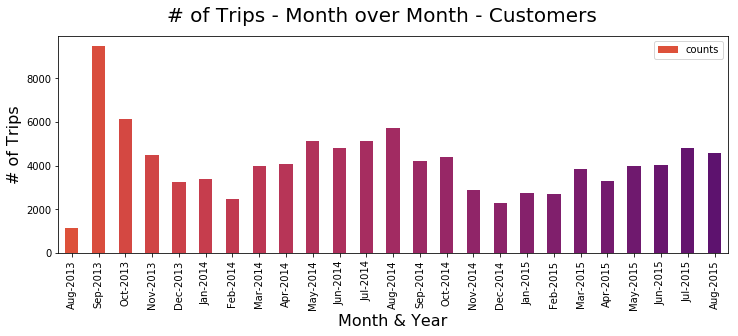

In [114]:
bikeshare_cus_clean['counts'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('# of Trips - Month over Month - Customers', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

The subscriber segment is extremely similar to the overall dataset. However, the customer segment is extremely different. In fact, we can see a large drop in the number of customers using the service over time, along with an outlier in September 2013. This is a bit concering when it comes to revenues because customers tend to pay more for the service than subscribers (billed hourly unless they pay for the entire day). So, we should definitely recommend that management devote more resources to determine why there's a drop in customers. <br>

It's important to note that we can see some seasonality within the data. Summer months tend to have more trips than winter months.<br>

Now, let's look at duration and see if we can find anything else interesting. 

Text(0.5,0,'Month & Year')

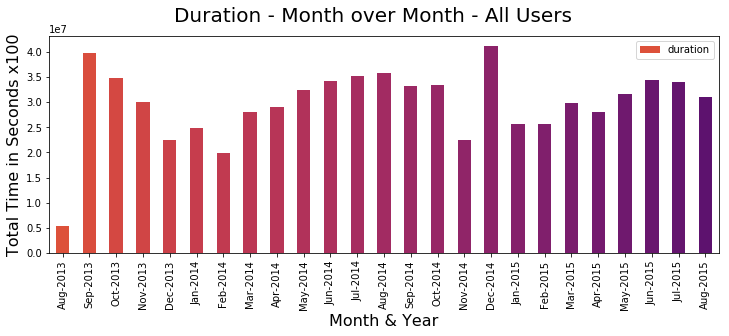

In [115]:
bikeshare_all_clean['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('Duration - Month over Month - All Users', fontsize=20)
plt.ylabel('Total Time in Seconds x100', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

Text(0.5,0,'Month & Year')

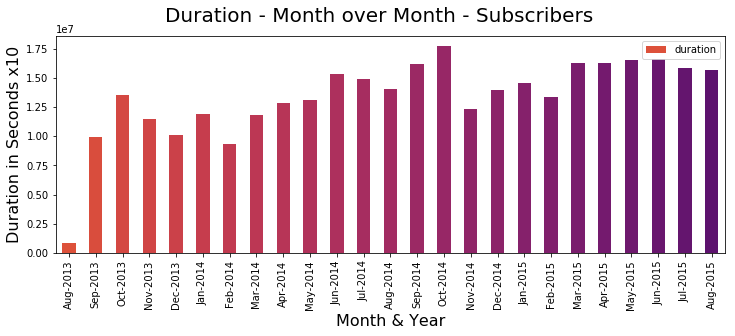

In [116]:
bikeshare_sub_clean['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('Duration - Month over Month - Subscribers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

Text(0.5,0,'Month & Year')

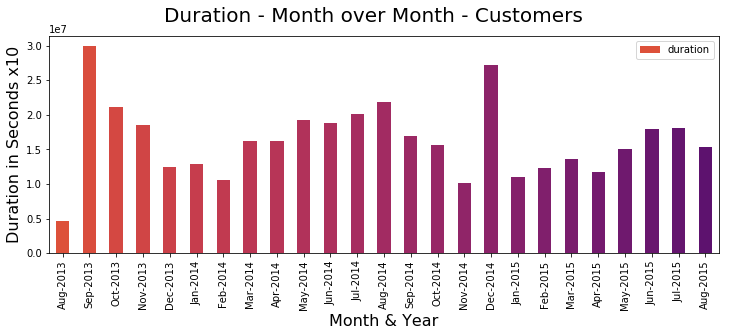

In [117]:
bikeshare_cus_clean['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
dates = [str(month) + '-' + str(year) for year in range(2013,2016) for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
plt.xticks(range(0,25), dates[7:-4])
plt.suptitle('Duration - Month over Month - Customers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('Month & Year', fontsize=16)

The duration for subscribers seems to be gradually increasing over time, but duration may be flattening. When we look at customers, we can see some seasonality in the duration of trips as well. There are clear outliers in Sep 2013 and Dec 2014, we can see the ebbs and flows within the dataset. We should spend some time digging into Sept 2013 and figure out why that month is an outlier. 

#### By Day of Week

In [118]:
sfsubscriber = sftrips_clean.loc[sftrips_clean['subscription_type'] == 'Subscriber']
sfcustomer = sftrips_clean.loc[sftrips_clean['subscription_type'] == 'Customer']

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'Day of Week')

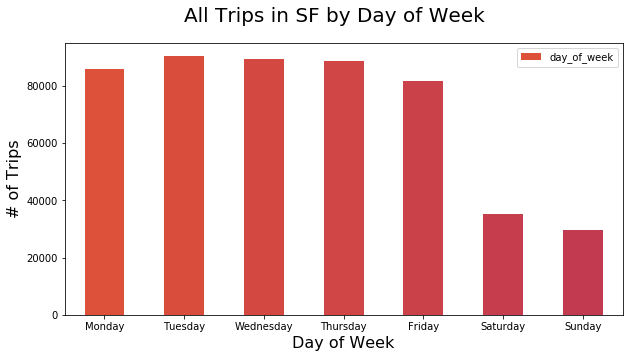

In [119]:
sftrips_clean['day_of_week'] = pd.Categorical(sftrips_clean['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
trips_by_day = sftrips_clean['day_of_week'].value_counts().sort_index()
trips_by_day.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('All Trips in SF by Day of Week', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

Most trips appear to happen during the week. Seems to fall in alignment with our story. Let's segment the data into customers and subscribers and see if there is a difference in the frequency of trips by day of the week

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'Day of Week')

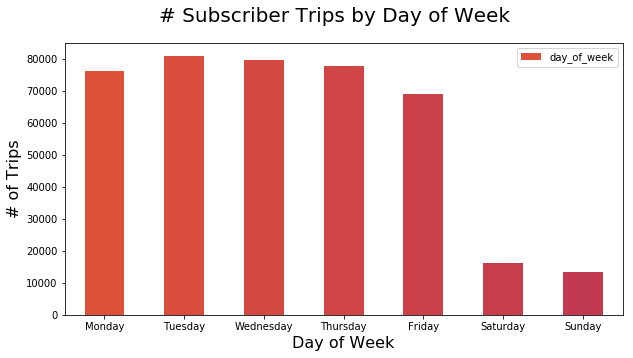

In [120]:
sfsubscriber['day_of_week'] = pd.Categorical(sfsubscriber['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
sub_trips_by_day = sfsubscriber['day_of_week'].value_counts().sort_index()
sub_trips_by_day.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('# Subscriber Trips by Day of Week', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'Day of Week')

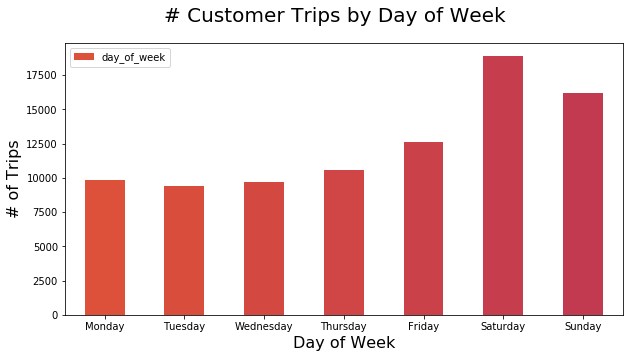

In [121]:
sfcustomer['day_of_week'] = pd.Categorical(sfcustomer['day_of_week'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)
cus_trips_by_day = sfcustomer['day_of_week'].value_counts().sort_index()
cus_trips_by_day.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('# Customer Trips by Day of Week', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

Interesting! Again, this makes intuitive sense. Our subscribers are Bay Area residents and are using the bikes to commute. So, the days with the highest traffic are Mon - Fri. However, when we look at the customers graph we can see that most trips occur on Friday, Saturday, & Sunday. I believe it's safe to assume that our customers are mostly tourists & out of towners with the occasional local who needs a bike.<br><br>
Now let's take a look at duration by day of week. 

Text(0.5,0,'Day of Week')

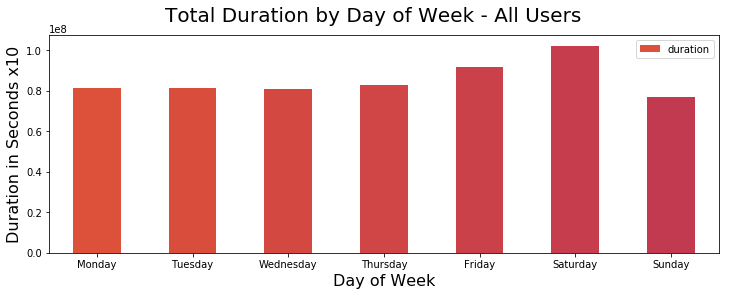

In [122]:
duaration_all = sftrips_clean.groupby(sftrips_clean.day_of_week).sum()
duaration_all['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Total Duration by Day of Week - All Users', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

Text(0.5,0,'Day of Week')

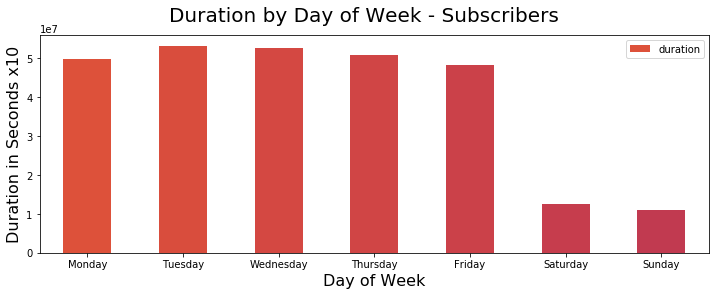

In [123]:
duaration_sub = sfsubscriber.groupby(sfsubscriber.day_of_week).sum()
duaration_sub['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Duration by Day of Week - Subscribers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

Text(0.5,0,'Day of Week')

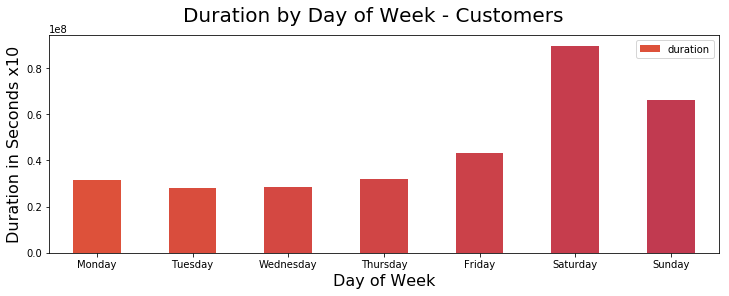

In [124]:
duaration_cus = sfcustomer.groupby(sfcustomer.day_of_week).sum()
duaration_cus['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Duration by Day of Week - Customers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)

Pretty interesting! Just like the number of trips, we can see that the duration of trip depends on the day of the week and whether or not the user is a customer or a subscriber. <br><br>
Let's take a look at the number of trips by hour to see if it helps build our story even further. 

#### By Hour

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'24 Hour Clock')

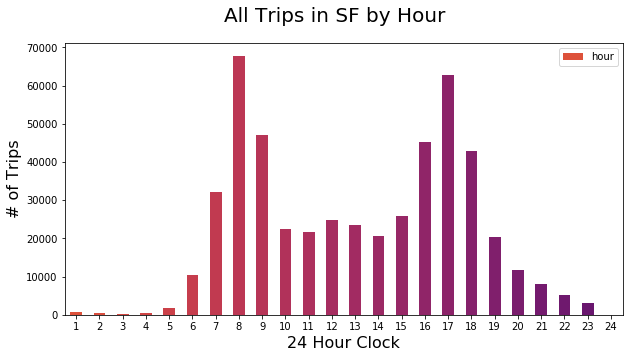

In [125]:
sftrips_clean['hour'] = pd.Categorical(sftrips_clean['hour'], categories=range(1,25), ordered=True)
trips_by_hour = sftrips_clean['hour'].value_counts().sort_index()
trips_by_hour.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('All Trips in SF by Hour', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'24 Hour Clock')

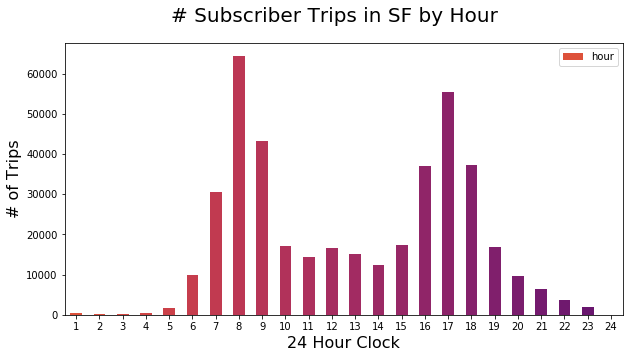

In [126]:
sfsubscriber['hour'] = pd.Categorical(sfsubscriber['hour'], categories=range(1,25), ordered=True)
sub_trips_by_hour = sfsubscriber['hour'].value_counts().sort_index()
sub_trips_by_hour.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('# Subscriber Trips in SF by Hour', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

/Users/matthewfederighi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Text(0.5,0,'24 Hour Clock')

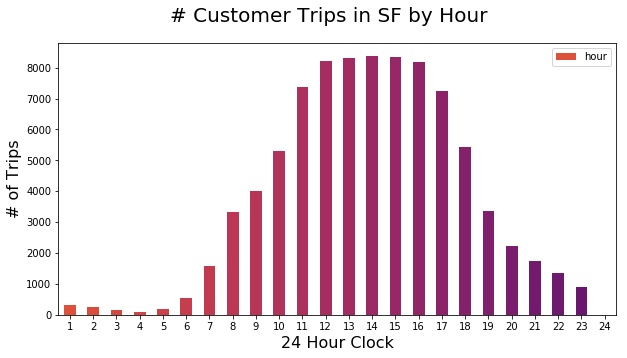

In [128]:
sfcustomer['hour'] = pd.Categorical(sfcustomer['hour'], categories=range(1,25), ordered=True)
cus_trips_by_hour = sfcustomer['hour'].value_counts().sort_index()
cus_trips_by_hour.plot(kind='bar', stacked=True, color=color, legend=True, figsize=(10,5))
plt.xticks(rotation=0)
plt.suptitle('# Customer Trips in SF by Hour', fontsize=20)
plt.ylabel('# of Trips', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

Very cool! We can see that the prime time for subscribers is during peak commuter hours. Afains, this makes sesne because our subscribers are using the service to commute to work. When we look at the customers, we see a nice curve that peaks in the early afternoon and slowly tapers off after that.<br><br>
It's critical that we broke out the data into both customers and subscribers because as we can see from the above graphs, the distributions for each segment are significantly different. Breaking this out into 2 different segments allows us to gather a much clearer picture of our user habits and trends. <br><br>
For fun, let's take a look at the duration by hour to see if we can learn anything. 

Text(0.5,0,'24 Hour Clock')

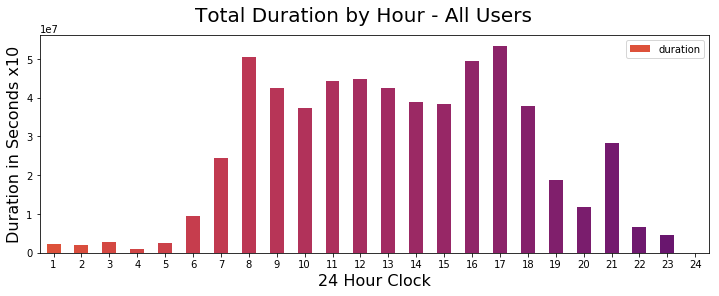

In [145]:
duration_all = sftrips_clean.groupby(sftrips_clean.hour).sum()
duration_all['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Total Duration by Hour - All Users', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

Text(0.5,0,'24 Hour Clock')

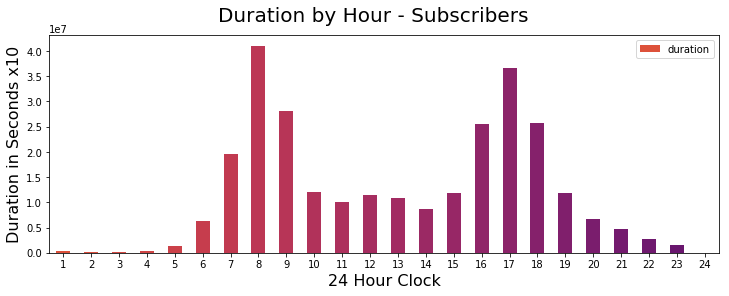

In [146]:
duration_sub_hour = sfsubscriber.groupby(sfsubscriber.hour).sum()
duration_sub_hour['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Duration by Hour - Subscribers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

Text(0.5,0,'24 Hour Clock')

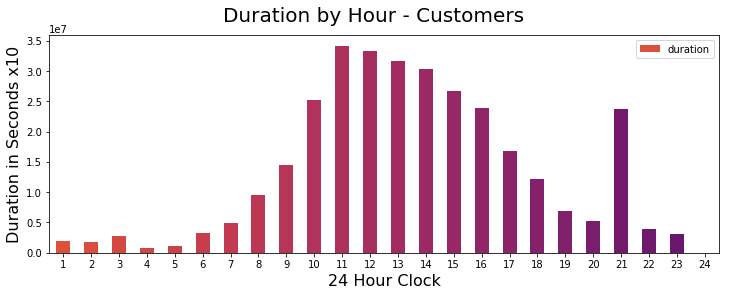

In [147]:
duration_cus_hour = sfcustomer.groupby(sfcustomer.hour).sum()
duration_cus_hour['duration'].plot(kind='bar', stacked=True, color=color, legend=True, figsize=(12,4))
plt.xticks(rotation=0)
plt.suptitle('Duration by Hour - Customers', fontsize=20)
plt.ylabel('Duration in Seconds x10', fontsize=16)
plt.xlabel('24 Hour Clock', fontsize=16)

Great! Just as we expected from the number of trips, we can see that the total duration of trips depends on whether the user is a customer or a subscriber. One thing to note is the large spike in hour 21 (9pm PST). It seems a bit strange that duration would be so high there. One explanation could be that customers are riding the bikes to and from nighlight in San Francisco. If we wanted to dive deeper into that, we could break out the data into Customers only, looking at the stations they travel to at 9pm. 

# 4. Does the Weather Impact # of Trips and Duration? 

In [163]:
# since we were only looking at the SF trips data, let's only look at the SF weather data
sfweather = pd.read_sql_query('SELECT * FROM weather WHERE zip_code = "94107";',conn)
sfweather.date = pd.DatetimeIndex(sfweather.date, format='%m/%d/%Y')
sfweather.set_index('date', inplace=True)
sfweather.head()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
date,,,,,,,,,,,,,,,,,,,,,
2013-08-29,74,68,61,61,58,56,93,75,57,30.07,...,10,10,23,11,28,0,4,,286,94107
2013-08-30,78,69,60,61,58,56,90,70,50,30.05,...,10,7,29,13,35,0,2,,291,94107
2013-08-31,71,64,57,57,56,54,93,75,57,30.00,...,10,10,26,15,31,0,4,,284,94107
2013-09-01,74,66,58,60,56,53,87,68,49,29.96,...,10,10,25,13,29,0,4,,284,94107
2013-09-02,75,69,62,61,60,58,93,77,61,29.97,...,10,6,23,12,30,0,6,,277,94107


In [164]:
sfweather.dtypes

max_temperature_f                   int64
mean_temperature_f                  int64
min_temperature_f                   int64
max_dew_point_f                     int64
mean_dew_point_f                    int64
min_dew_point_f                     int64
max_humidity                        int64
mean_humidity                       int64
min_humidity                        int64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles                int64
mean_visibility_miles               int64
min_visibility_miles                int64
max_wind_Speed_mph                  int64
mean_wind_speed_mph                 int64
max_gust_speed_mph                 object
precipitation_inches               object
cloud_cover                         int64
events                             object
wind_dir_degrees                    int64
zip_code                            int64
dtype: object

Looks like we need to fix some of this data. max_gust_speed_mph and precipitation_inches are of type object and we need to convert them to numeric values for analysis. We also need to look at the events data and see if that is categorical or numeric. Once we determine that, we can decide next steps. 

In [165]:
# Check for unique values in events column.. We need to change values for consistency
sfweather.events.unique()

array(['', 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

Interesting, looks like we have a blank value, and two different rain values. Let's clean that up. 

In [166]:
sfweather.loc[sfweather.events == 'rain', 'events'] = "Rain"
sfweather.loc[sfweather.events == '', 'events'] = "Normal"
sfweather.events.unique()

array(['Normal', 'Fog', 'Rain', 'Fog-Rain', 'Rain-Thunderstorm'],
      dtype=object)

Now that we know it's categorical data, let's create some dummy variables

In [167]:
# Create dummy variables for each
events = pd.get_dummies(sfweather.events)
sfweather = sfweather.merge(events, left_index = True, right_index = True)

And finally, let's clean this dataframe up a bit. 

In [168]:
# Drop unnecessary columns, Check remaining variables for appropriate types
sfweather = sfweather.drop(['events','zip_code'],1)
sfweather.dtypes

max_temperature_f                   int64
mean_temperature_f                  int64
min_temperature_f                   int64
max_dew_point_f                     int64
mean_dew_point_f                    int64
min_dew_point_f                     int64
max_humidity                        int64
mean_humidity                       int64
min_humidity                        int64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles                int64
mean_visibility_miles               int64
min_visibility_miles                int64
max_wind_Speed_mph                  int64
mean_wind_speed_mph                 int64
max_gust_speed_mph                 object
precipitation_inches               object
cloud_cover                         int64
wind_dir_degrees                    int64
Fog                                 uint8
Fog-Rain                            uint8
Normal                            

Great! Now let's fix max_gust_speed_mph and precipitation_inches

In [169]:
# Convert to int. If there are blanks or strings, convert to NaN with coerce
sfweather.max_gust_speed_mph = pd.to_numeric(sfweather.max_gust_speed_mph, errors = 'coerce')
# Then check to see if there are any nulls
pd.isnull(sfweather.max_gust_speed_mph).sum()

13

In [170]:
# 13 blank values! Lets fill them with the median 
sfweather.loc[sfweather.max_gust_speed_mph.isnull(), 
            'max_gust_speed_mph'] = sfweather[sfweather.max_gust_speed_mph.notnull()].max_gust_speed_mph.median()
# Check for blank values to confirm
pd.isnull(sfweather.max_gust_speed_mph).sum()

0

In [171]:
# Convert to int. If there are blanks or strings, convert to NaN with coerce
sfweather.precipitation_inches = pd.to_numeric(sfweather.precipitation_inches, errors = 'coerce')
# Then check to see if there are any nulls
pd.isnull(sfweather.precipitation_inches).sum()

70

In [172]:
# 70 blank values! Therefore, fill them with the median 
sfweather.loc[sfweather.precipitation_inches.isnull(), 
            'precipitation_inches'] = sfweather[sfweather.precipitation_inches.notnull()].precipitation_inches.median()
# Check for blank values to confirm
pd.isnull(sfweather.precipitation_inches).sum()

0

In [173]:
# Final check on the data types
sfweather.dtypes

max_temperature_f                   int64
mean_temperature_f                  int64
min_temperature_f                   int64
max_dew_point_f                     int64
mean_dew_point_f                    int64
min_dew_point_f                     int64
max_humidity                        int64
mean_humidity                       int64
min_humidity                        int64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles                int64
mean_visibility_miles               int64
min_visibility_miles                int64
max_wind_Speed_mph                  int64
mean_wind_speed_mph                 int64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                         int64
wind_dir_degrees                    int64
Fog                                 uint8
Fog-Rain                            uint8
Normal                            

In [174]:
pd.isnull(sfweather).sum()

max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

Looks good! Now let's merge this with the trips dataset and see if the weather has an affect on the number of trips and duration

In [175]:
merge=pd.merge(month_agg,sfweather, how='inner', left_index=True, right_index=True)
merge.head()

,counts,duration,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,...,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
date,,,,,,,,,,,,,,,,,,,,,
2013-08-29,748,1167850,74,68,61,61,58,56,93,75,...,11,28.0,0.0,4,286,0,0,1,0,0
2013-08-30,714,1930037,78,69,60,61,58,56,90,70,...,13,35.0,0.0,2,291,0,0,1,0,0
2013-08-31,640,2342473,71,64,57,57,56,54,93,75,...,15,31.0,0.0,4,284,0,0,1,0,0
2013-09-01,706,2404578,74,66,58,60,56,53,87,68,...,13,29.0,0.0,4,284,0,0,1,0,0
2013-09-02,661,1543638,75,69,62,61,60,58,93,77,...,12,30.0,0.0,6,277,0,0,1,0,0


In [180]:
# Dataframe is cutoff, let's check all the column names
merge.columns

Index(['counts', 'duration', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees', 'Fog', 'Fog-Rain', 'Normal', 'Rain',
       'Rain-Thunderstorm'],
      dtype='object')

In [185]:
lm1 = sm.formula.ols(formula='counts ~ mean_temperature_f + mean_humidity + mean_wind_speed_mph + precipitation_inches',data = merge).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 counts   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     16.10
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           1.21e-12
Time:                        19:49:43   Log-Likelihood:                -5405.5
No. Observations:                 733   AIC:                         1.082e+04
Df Residuals:                     728   BIC:                         1.084e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               76.5880 

In [184]:
lm2 = sm.formula.ols(formula='duration ~ mean_temperature_f + mean_humidity + mean_wind_speed_mph + precipitation_inches',data = merge).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     9.447
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           1.90e-07
Time:                        19:49:41   Log-Likelihood:                -10899.
No. Observations:                 733   AIC:                         2.181e+04
Df Residuals:                     728   BIC:                         2.183e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -6.857e+05 

Interesting, our R-squared is extremely low. I wonder why that is? Maybe because commuters tend not to care about the weather. They have to get to work, regardless of the weather. <br>
Note that we ran many regressions here, none of which were giving significant results. We created the dummy variables here and didn't include them in the above regressions because they were insignificant. Also, whether or not it rained in a single day doesn't necessarily mean people will not ride bicycles. It could rain for 1 hour in the beginning of the day, but then the weather is sunny the rest of the day. So, a dummy variable is not very precise in this situation. Total precipitation is a much better indicator (intuitively). <br><br>
So, what did we learn here? Well, overall the duration and # of trips in San Francisco is pretty flat. There are limited signs of growth and seasonlity is clear in some aspects of the data. It's also surprising that weather does not seem to have an impact on the number of trips or trip duration. San Francisco has relatively stable weather and only 12% of the weather data had rain. Retrospectively, this makes sense why weather does not have a major impact on the # of trips or the duration of trips. If weather is relatively stable, then we won't necessarily see an impact. In cities where the weather is more extreme, we would likely see that weather is impactful.